In [135]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

SEED = 42
np.random.seed(42)

In [136]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

df_wine = pd.read_csv(url, delimiter=';')

print(df_wine.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

Valores nulos en x:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64
Valores nulos en y: 0


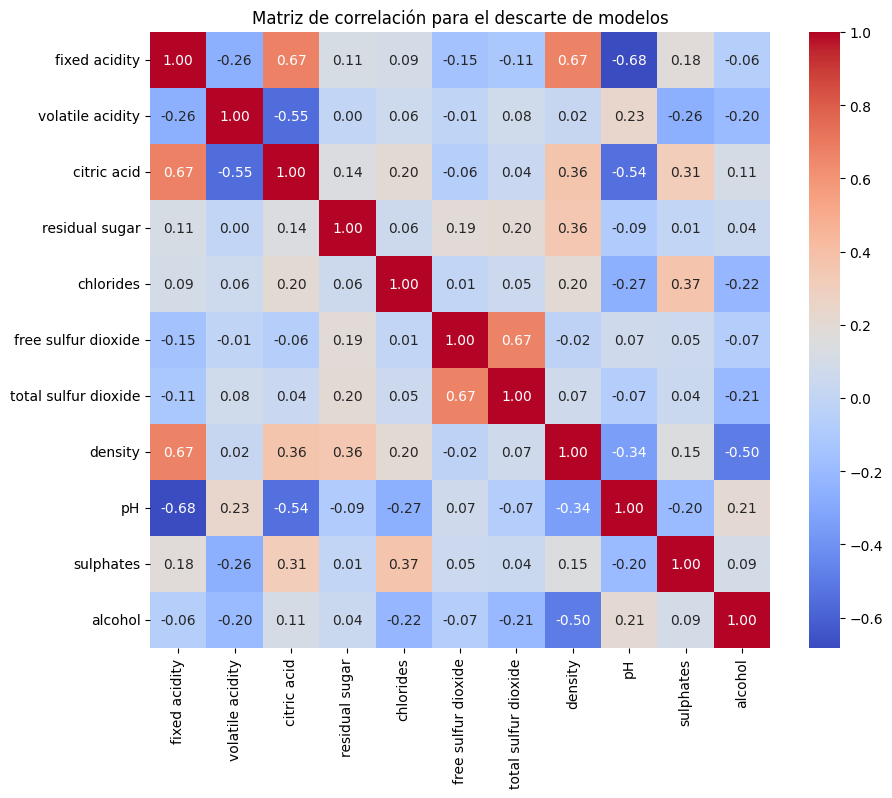

In [137]:
#Division
x = df_wine.drop('quality', axis=1)
y = df_wine['quality']

# Comprobacion de nulos
print(f"Valores nulos en x:\n{np.isnan(x).sum()}")
print(f"Valores nulos en y: {np.isnan(y).sum()}")

#Matriz de correlacion
plt.figure(figsize=(10,8))
sns.heatmap(x.corr(),annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de correlación para el descarte de modelos")
plt.show()

In [138]:
# Se utiliza KNN
print(f"Dataset cargado: {x.shape[0]} muestras, {x.shape[1]} caracteristicas")
print(f"Distribucion de las clases {np.bincount(y)}")

Dataset cargado: 1599 muestras, 11 caracteristicas
Distribucion de las clases [  0   0   0  10  53 681 638 199  18]


In [139]:
# Clases desbalanceadas
# Se agrupan las clases:
# 0 = bajo (3 - 5)
# 1 = medio (6)
# 2 = alto (7 - 8)

df_wine['quality_cat'] = df_wine['quality'].apply(lambda x: 0 if x <= 5 else (1 if x == 6 else 2))

x = df_wine.drop('quality_cat', axis=1)
y = df_wine['quality_cat']

print(f"Distribucion de las clases {np.bincount(y)}")

Distribucion de las clases [744 638 217]


In [140]:
# Division (Entrenamiento | Test)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=SEED, stratify=y)

print(f"\nDATOS DIVIDIDOS:")
print(f"   - Entrenamiento: {x_train.shape[0]} muestras")
print(f"   - Prueba: {x_test.shape[0]} muestras")
print(f"   - Distribución entrenamiento: {np.bincount(y_train)}")
print(f"   - Distribución prueba: {np.bincount(y_test)}")

# escalado
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)



DATOS DIVIDIDOS:
   - Entrenamiento: 1119 muestras
   - Prueba: 480 muestras
   - Distribución entrenamiento: [521 446 152]
   - Distribución prueba: [223 192  65]


K ÓPTIMO ENCONTRADO: 1
Precisión con validación cruzada: 0.9374


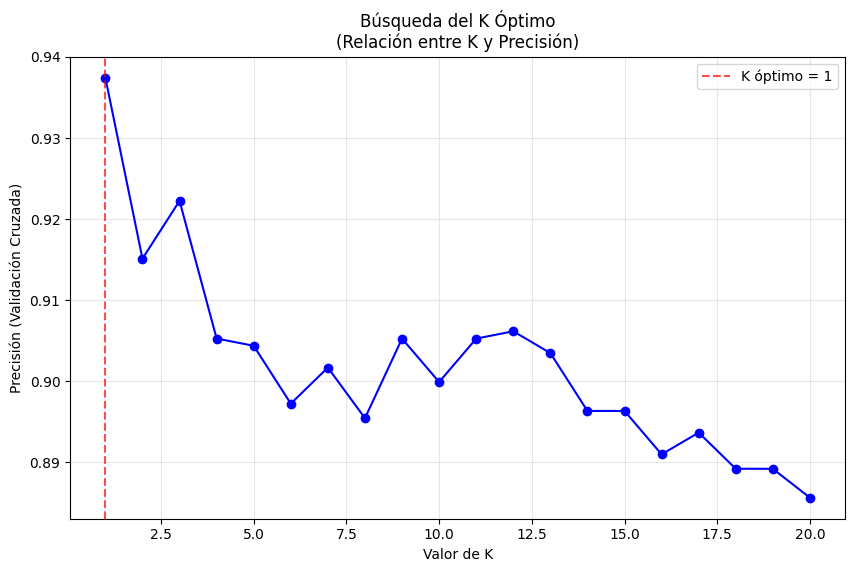

In [141]:
from sklearn.model_selection import cross_val_score

# Probar diferentes valores de k
k_range = range(1, 21)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Usar validación cruzada para evaluación más robusta
    scores = cross_val_score(knn, x_train_scaled, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

# Encontrar K óptimo
optimal_k = k_range[np.argmax(k_scores)]
optimal_score = max(k_scores)

print(f"K ÓPTIMO ENCONTRADO: {optimal_k}")
print(f"Precisión con validación cruzada: {optimal_score:.4f}")

# Graficar relación K vs Precisión
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o', linestyle='-', color='b')
plt.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.7, label=f'K óptimo = {optimal_k}')
plt.xlabel('Valor de K')
plt.ylabel('Precisión (Validación Cruzada)')
plt.title('Búsqueda del K Óptimo\n(Relación entre K y Precisión)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [142]:
# Entranamiento
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_train_scaled, y_train)

# Prediccion y Evaluacion
y_pred = model.predict(x_test_scaled)
y_pred_proba = model.predict_proba(x_test_scaled)

accuracy = accuracy_score(y_test, y_pred)

print("Modelo K=1")
print(f"Precision en entrenamiento: {model.score(x_train_scaled, y_train):.4f}")
print(f"Precision en prueba: {accuracy:.4f}\n")

print("Reporte de clasificación - k=1")
print(classification_report(y_test, y_pred)) #target_names=['bajo','medio','alto']

Modelo K=1
Precision en entrenamiento: 0.9598
Precision en prueba: 0.9333

Reporte de clasificación - k=1
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       223
           1       0.89      0.96      0.92       192
           2       1.00      0.78      0.88        65

    accuracy                           0.93       480
   macro avg       0.95      0.90      0.92       480
weighted avg       0.94      0.93      0.93       480



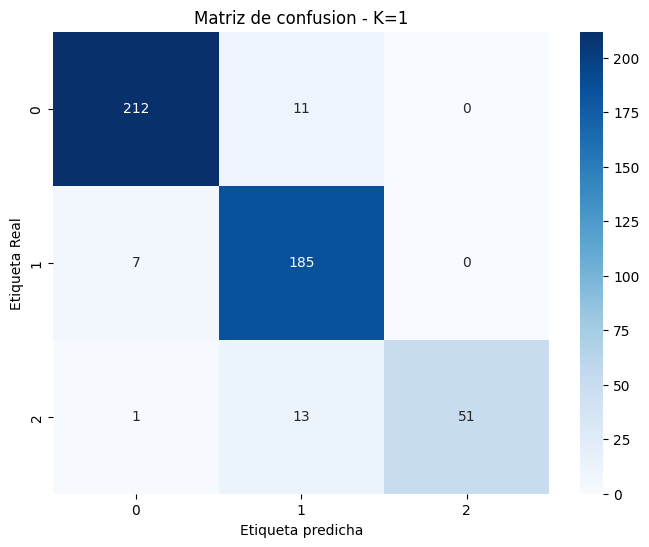

In [143]:
# Matriz de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues'
            #xticklabels=['bajo','medio','alto'],
            #yticklabels=['bajo','medio','alto']
            )
plt.title("Matriz de confusion - K=1")
plt.ylabel("Etiqueta Real")
plt.xlabel("Etiqueta predicha")
plt.show()